In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Dataset import *
from Metric import *
from Model import *
from Preprocess import *
from train import *
from tqdm.auto import trange
import torch.nn.functional as F
from config import config

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = pd.read_csv("../data/final.csv")
data['YearMonth'] = pd.to_datetime(data['YearMonth'])
data.set_index('YearMonth', inplace=True)
tst_size=20
trn, tst = data[:-tst_size], data[-tst_size:]

In [11]:
statelesslstmmodel = torch.load("./modelpth/Stateless/Stateless_tst_size_20_AdamW_epochs_500_lr_2e-05_hidden_size_64_window_size64.pth")
statelessParam = config['Stateless']['model_params']

In [12]:
stateless_input_size = statelessParam['stateless_input_size']
stateless_hidden_size =statelessParam['stateless_hidden_size']
stateless_output_size =statelessParam['stateless_output_size']
stateless_num_layers = statelessParam['stateless_num_layers']
stateless_window_size =statelessParam['stateless_window_size']

In [13]:
statefullstm = StatefulLoadData(data,tst_size)
state_trn_scaled, state_tst_scaled = statefullstm.scaling()
trn_x = torch.tensor(state_trn_scaled[:-1]).split(config['Stateful']['model_params']['state_batch_size'])
trn_y = torch.tensor(state_trn_scaled[1:]).split(config['Stateful']['model_params']['state_batch_size'])
tst_y = torch.tensor(state_tst_scaled)

In [14]:
statelesslstm = StatelessLoadData(data,tst_size, stateless_window_size)
state_trn_scaled, state_tst_scaled = statelesslstm.scaling()


In [15]:
a, b = next(iter(state_tst_scaled))
#a = a[-1]
statelesslstmmodel.to(device)
statelesslstmmodel.eval()
with torch.inference_mode():
    p = statelesslstmmodel.predict(a[0].to(device), len(tst_y))

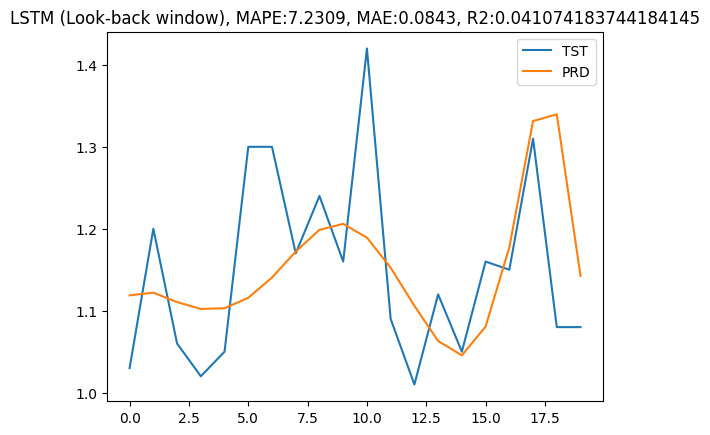

In [16]:
p=p[:,:1]
#p = p.reshape(-1,1)

scaler = statelesslstm.get_scaler()
prd = scaler.inverse_transform(p.cpu())
# prd = p.cpu()

plt.title(f"LSTM (Look-back window), MAPE:{mape(prd,tst.to_numpy()):.4f}, MAE:{mae(prd,tst.to_numpy()):.4f}, R2:{r2_score(prd,tst.to_numpy())}")
plt.plot(tst.to_numpy()[:,:1], label='TST')
plt.plot(prd, label='PRD')
plt.legend()
plt.show()